# German wings review challenge

The notebook shows two use cases.
The data is found in a text file holding a set of reviews about the German wings airline (airline code ‘4U’).


- ## First use case:
The goal of this use case is to show that based on the customer review data how to predict the target variable 'Recommended'.


- ## Second use case:
The goal of the second use case is to find topics in the reviews.


The notebook covers the following topics:

- #### Data loading
    - loading the customer review data from txt to dataframe

- #### EDA
    - plotting distribution of the variables
    - plotting histograms
    - showing relationship between target variables to other variables
    - text analysis
        - plotting word frequencies
        - topic modeling with LDA
    
- #### Feature engineering
    - tfidf
    - count features
    - word embedding
        - glove
    
- #### Evaluation
    - logloss
    - roc curve
    - precision recall curve

- #### Machine learning models
    - logistic regression
    - navie bayes
    - gradient boost machine
        - xgboost
    - deep learning
        - lstm
        - gru
        - bidirectional lstm

- #### Error analysis


In [340]:
import collections
from collections import Counter

import sys, os, re, csv, codecs, math, logging, base64

from datetime import datetime

import statsmodels.formula.api as smf

import pandas as pd
from pandas.api.types import is_string_dtype, is_numeric_dtype

import numpy as np
from numpy import inf

from scipy import stats, interp
from scipy.stats import skew, norm
from scipy.stats import randint as sp_randint
from scipy.misc import imread

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import pyplot
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, label_binarize
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_absolute_error, mean_squared_error, confusion_matrix
from sklearn.metrics import classification_report, precision_recall_curve, precision_recall_fscore_support
from sklearn.metrics import accuracy_score, average_precision_score
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.utils.fixes import signature
 

import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

import lightgbm as lgb

from hyperopt import hp, tpe, STATUS_OK, Trials
from hyperopt.fmin import fmin

from tqdm import tqdm

import keras
from keras.utils import np_utils
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence, text
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.callbacks import EarlyStopping

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')

#stop_words = nltk.download('stopwords')
stop_words = stopwords.words('english')

from wordcloud import WordCloud, STOPWORDS

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

[11:16:59] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


[nltk_data] Downloading package punkt to /Users/kai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Load Data

In [244]:
# TODO: Refactor this function
def get_df_review(filename='4U_Reviews.txt', encoding = "ISO-8859-1"):
    """
    Load data in the txt file into a pandas dataframe.
    
    - Loop the text lines of the file.
    - For each text line
        - If the text line is not an empty line, then add the text line to the list.
        - Else I process the date in the list and save the processed data into the dictionary. After that, I clean the list.
    - At the end of the text, I convert the dictionary into a pandas dataframe.
    """

    #map the content to dictionary
    dict_review = {'Title':[], 
                   'User Name':[], 
                   'Country':[], 
                   'Date':[],
                   'Rating':[], 
                   'Review':[], 
                   'Type Of Traveller':[], 
                   'Cabin Flown':[], 
                   'Route':[], 
                   'Date Flown':[], 
                   'Seat Comfort':[], 
                   'Cabin Staff Service':[], 
                   'Ground Service':[], 
                   'Value For Money':[], 
                   'Recommended':[]
                  }

    other_info_names = ['Type Of Traveller', 
                        'Cabin Flown', 
                        'Route', 
                        'Date Flown', 
                        'Seat Comfort', 
                        'Cabin Staff Service', 
                        'Ground Service', 
                        'Value For Money', 
                        'Recommended'
                       ]
    
    f = open(filename, "r", encoding = encoding)
    
    # The list is used to save temporal review data. 
    review_info_list = [] 
    for line in f:
        if line == '\n':
            #print("-----")
            #print(review_info_list)

            # get Title, User Name, Country, Date, Rating, Review
            for i, line in enumerate(review_info_list):
                # get title
                if i == 0:
                    #print('title: {}'.format(line))
                    dict_review['Title'].append(line)
                # get user name, country, date
                elif i == 1:
                    user_name = ''
                    country_name = ''
                    date_str = ''
                    
                    pos_start = line.find('(')
                    pos_end = line.find(')')
                    if pos_start != -1:
                        user_name = line[0:pos_start].strip()
                        country_name = line[pos_start+1:pos_end].strip()
                        date_str = line[pos_end+1:].strip()
                    else:
                        str_list = line.split()
                        if len(str_list) == 5:
                            user_name = str_list[0] + ' ' + str_list[1]
                            country_name = ''
                            date_str = str_list[-3].strip() + ' ' + str_list[-2].strip() + ' ' + str_list[-1].strip()
                        
                    #print('user name: {}'.format(user_name))
                    #print('country name: {}'.format(country_name))
                    #print('date: {}'.format(date_str))
                    dict_review['User Name'].append(user_name)
                    dict_review['Country'].append(country_name)
                    dict_review['Date'].append(date_str)
                # get rating
                elif i == 2:
                    if line.strip() == 'na':
                        rating = np.nan
                    else:
                        rating = int(line.strip())
                    #print('rating: {}'.format(rating))
                    dict_review['Rating'].append(rating)
                # get review
                elif i == 3:
                    #print('review')
                    #print(line.strip())
                    dict_review['Review'].append(line.strip())
            
            # get other information     
            for info_name in other_info_names:
                review_info = ''
                for i, line in enumerate(review_info_list):
                    pos = line.find(info_name)
                    if pos != -1:
                        review_info = line[len(info_name)+1:].strip()
                        break
                dict_review[info_name].append(review_info)

            review_info_list = [] 
        else:
            line = line.replace('\"', '')
            #print(line)
            review_info_list.append(line)

    df_review = pd.DataFrame(dict_review)
    
    # get route to and route from   
    def f_from(x):
        if x:
            return x.split()[0]
        return ''
    def f_to(x):
        if x:
            return x.split()[2]
        return ''
    df_review['Route From'] = df_review['Route'].apply(f_from)
    df_review['Route To'] = df_review['Route'].apply(f_to)
    
    return df_review    

In [245]:
df_review = get_df_review()

## 2. EDA and Data Processing

In [249]:
df_review.head()

,Title,User Name,Country,Date,Rating,Review,Type Of Traveller,Cabin Flown,Route,Date Flown,Seat Comfort,Cabin Staff Service,Ground Service,Value For Money,Recommended,Route From,Route To
0,they have been unresponsive\n,Brian McNamee,Canada,16th October 2015,2.0,We flew with Germanwings (or tried to) on Sept...,Couple Leisure,Economy,Stuttgart to Amsterdam,September 2015,12345,12345,12345,12345,no,Stuttgart,Amsterdam
1,I was refused some water\n,L Mouratidou,United Kingdom,4th October 2015,3.0,I am less than impressed with Germanwings serv...,Solo Leisure,Economy,Hamburg to London,September 2015,12345,12345,12345,12345,no,Hamburg,London
2,the service crew were friendly but nothing more\n,H Mutschler,Germany,21st September 2015,3.0,Flew from Palma de Mallorca to Cologne with Ge...,Couple Leisure,Economy,PMI to CGN,September 2015,12345,12345,12345,12345,no,PMI,CGN
3,"no problems or delays, very friendly staff\n",Oliver Numrich,Germany,20th September 2015,10.0,Good flight from Berlin-Tegel to London Heathr...,Business,,Berlin-Tegel to London Heathrow,August 2015,12345,12345,12345,12345,yes,Berlin-Tegel,London
4,I don't get why Germanwings is always late\n,Andreas Huettenhoelscher,Germany,14th September 2015,4.0,I don't get why Germanwings is always late and...,Business,Economy,CGN to LHR,September 2015,12345,12345,12345,12345,no,CGN,LHR


In [250]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127 entries, 0 to 126
Data columns (total 17 columns):
Title                  127 non-null object
User Name              127 non-null object
Country                127 non-null object
Date                   127 non-null object
Rating                 114 non-null float64
Review                 127 non-null object
Type Of Traveller      127 non-null object
Cabin Flown            127 non-null object
Route                  127 non-null object
Date Flown             127 non-null object
Seat Comfort           127 non-null object
Cabin Staff Service    127 non-null object
Ground Service         127 non-null object
Value For Money        127 non-null object
Recommended            127 non-null object
Route From             127 non-null object
Route To               127 non-null object
dtypes: float64(1), object(16)
memory usage: 16.9+ KB


In [251]:
df_review.shape

(127, 17)

### 2.1 Analyse target variable 'Recommended' 

In [252]:
df_review['Recommended'].describe()

count     127
unique      2
top        no
freq       65
Name: Recommended, dtype: object

In [253]:
df_review['Recommended'].unique()

array(['no', 'yes'], dtype=object)

In [254]:
df_review['Recommended'].isnull().sum()

0

In [255]:
# Transfer string into integer
lbl_enc = preprocessing.LabelEncoder()
df_review['Recommended Label'] = lbl_enc.fit_transform(df_review['Recommended'].values)

[09:42:25] DEBUG update_title_pos
[09:42:25] DEBUG update_title_pos
[09:42:25] DEBUG update_title_pos
[09:42:25] DEBUG update_title_pos
[09:42:25] DEBUG update_title_pos


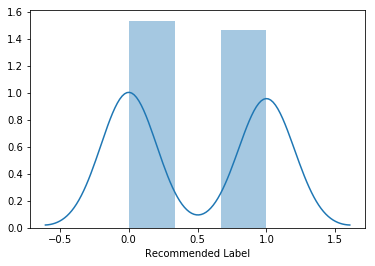

In [256]:
sns.distplot(df_review['Recommended Label'])

In [257]:
df_review[df_review['Recommended Label'] == 1].shape

(62, 18)

In [258]:
df_review[df_review['Recommended Label'] == 0].shape

(65, 18)

It shows the data between the two classes is balanced.

### 2.2 Analyse variable 'Rating' 

In [259]:
df_review['Rating'].describe()

count    114.000000
mean       5.587719
std        2.874395
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       10.000000
Name: Rating, dtype: float64

In [278]:
df_review['Rating'].unique()

array([ 2.,  3., 10.,  4.,  1.,  7.,  5.,  9.,  8., nan,  6.])

In [260]:
df_review['Rating'].isnull().sum()

13

In [261]:
df_review[df_review['Rating'].notnull()].shape

(114, 18)

In [262]:
df_review.shape

(127, 18)

[09:56:09] DEBUG update_title_pos
[09:56:09] DEBUG update_title_pos
[09:56:09] DEBUG update_title_pos
[09:56:09] DEBUG update_title_pos
[09:56:09] DEBUG update_title_pos


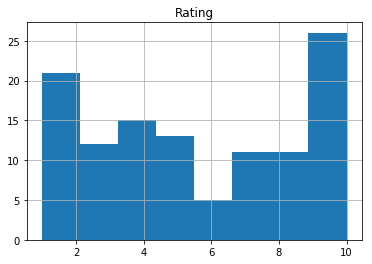

In [282]:
hist = df_review[df_review['Rating'].notnull()][['Rating']].hist(bins='auto')

### 2.3 Analyse Missing Numerical Data

In [283]:
total = df_review.isnull().sum().sort_values(ascending=False)
percent = (df_review.isnull().sum()/df_review.count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)
missing_data

,Total,Percent
Rating,13,0.114035
Recommended Label,0,0.000000
Route To,0,0.000000
User Name,0,0.000000
Country,0,0.000000
Date,0,0.000000
Review,0,0.000000
Type Of Traveller,0,0.000000
Cabin Flown,0,0.000000
Route,0,0.000000


It shows that 10% of the customer does not rate the flights.

### 2.4 Show relationship between 'Recommended' and other variables

- #### Relationship with numerical variables

In [284]:
def show_relation_numerical(df, var, target):
    data = pd.concat([df[target], df[var]], axis=1)
    data.plot.scatter(x=var, y=target)

[10:10:41] DEBUG update_title_pos
[10:10:41] DEBUG update_title_pos
[10:10:41] DEBUG update_title_pos
[10:10:41] DEBUG update_title_pos
[10:10:41] DEBUG update_title_pos


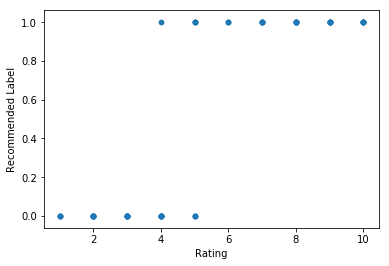

In [285]:
num_vars = ['Rating']
for num_var in num_vars:
    show_relation_numerical(df_review, num_var, 'Recommended Label')

It shows that 'Rating' is highly correlated with the target variable 'Recommended'.

- #### Relationship with categorical features

[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos


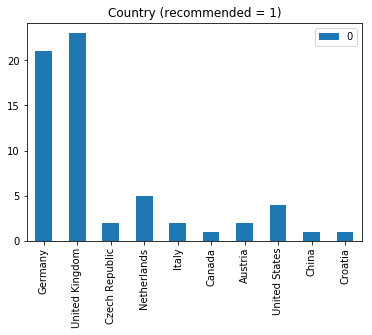

[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos


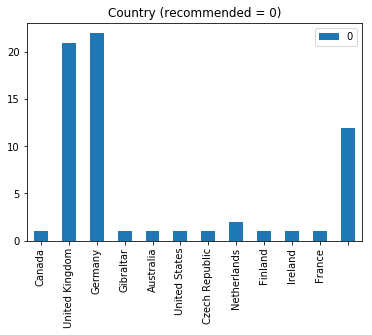

[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos
[10:15:29] DEBUG update_title_pos


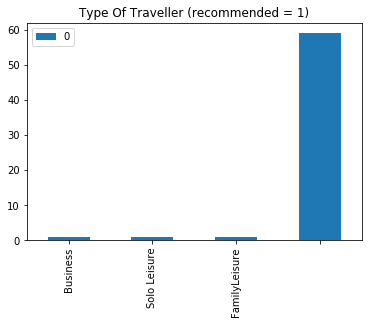

[10:15:29] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


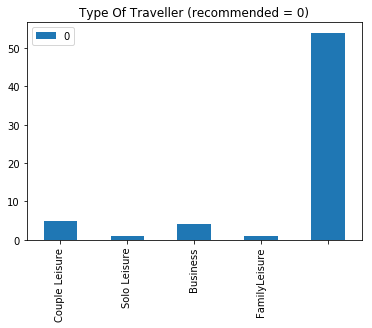

[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


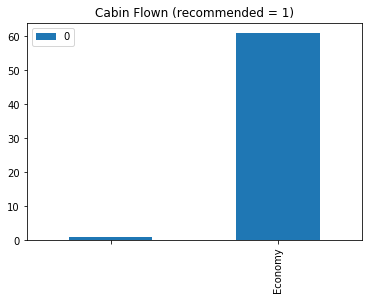

[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


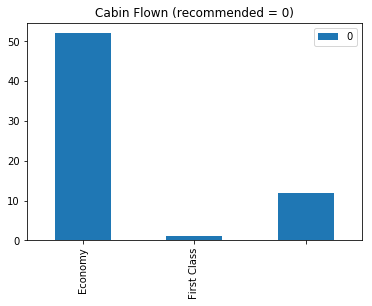

[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


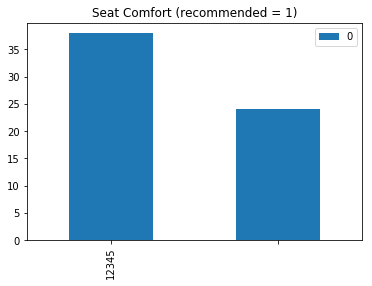

[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


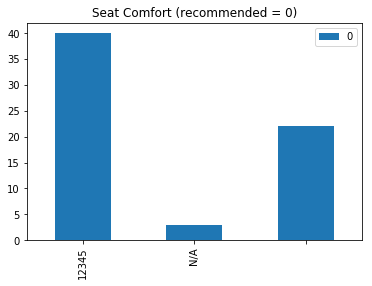

[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


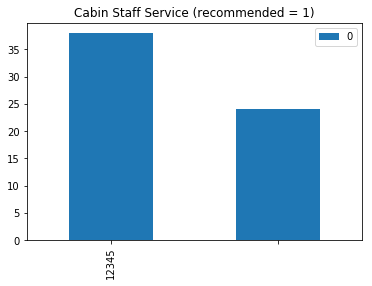

[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


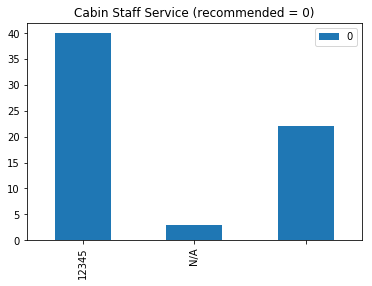

[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


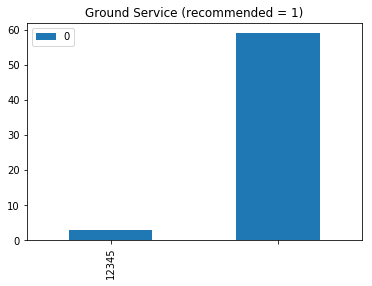

[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


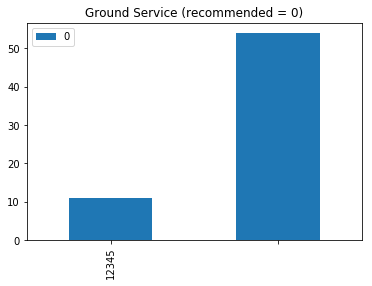

[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos
[10:15:30] DEBUG update_title_pos


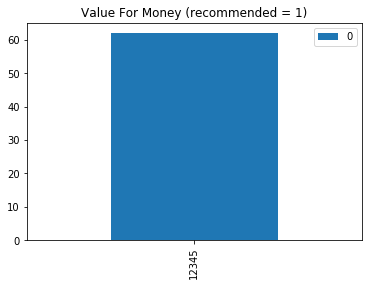

[10:15:31] DEBUG update_title_pos
[10:15:31] DEBUG update_title_pos
[10:15:31] DEBUG update_title_pos
[10:15:31] DEBUG update_title_pos


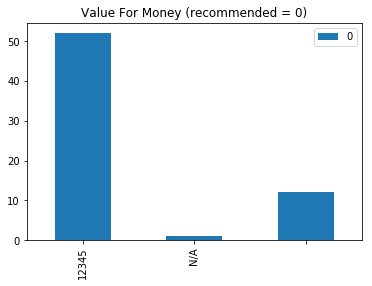

In [286]:
cat_vars = ['Country', 'Type Of Traveller', 'Cabin Flown', 'Seat Comfort', 'Cabin Staff Service', 'Ground Service', 'Value For Money']
                  
# https://stackoverflow.com/questions/28418988/how-to-make-a-histogram-from-a-list-of-strings-in-python
def plot_strings(a, title=''):
    letter_counts = Counter(a)
    df = pd.DataFrame.from_dict(letter_counts, orient='index')
    df.plot(kind='bar', title=title)
    
for cat_var in cat_vars:
    df = df_review[df_review['Recommended Label'] == 1][[cat_var]]
    plot_strings(df[cat_var].tolist(), title=cat_var+' (recommended = 1)')
    
    df = df_review[df_review['Recommended Label'] == 0][[cat_var]]
    plot_strings(df[cat_var].tolist(), title=cat_var+' (recommended = 0)')
    

It shows that there is a lot of missing data in the categorical features. The categorical features are not usefull to predict target variable 'Recommended'.

### 2.5 Text analysis

**Reference**

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

- ### Title

In [287]:
df_review['Title'].unique()

array(['they have been unresponsive\n', 'I was refused some water\n',
       'the service crew were friendly but nothing more\n',
       'no problems or delays, very friendly staff\n',
       "I don't get why Germanwings is always late\n",
       'vowing never to book Germanwings again\n',
       'staff friendly - food terrible\n',
       'no explanations, no offers of help\n',
       'delay in Heathrow about 1:30 minutes\n',
       'Germanwings customer review\n'], dtype=object)

[10:16:21] DEBUG update_title_pos
[10:16:21] DEBUG update_title_pos
[10:16:21] DEBUG update_title_pos
[10:16:21] DEBUG update_title_pos
[10:16:21] DEBUG update_title_pos


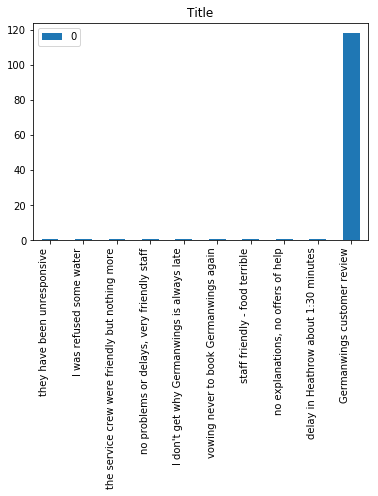

In [288]:
plot_strings(df_review['Title'], title='Title')

It shows that most of the reviews have the title 'Germanwings customer review'. Therefore, I will not use 'Title' as a feature to predict 'Recommended'

- ### Review

- Show top 50word frequencies of the reviews

In [289]:
df_review["Review"] = df_review["Review"].fillna("_na_").values

In [290]:
# The code is adapted from
# https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial
all_words = df_review["Review"].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

- Show top 50 word frequencies of positive reviews, i.e., recommended.

In [291]:
all_words = df_review[df_review['Recommended']=="yes"]["Review"].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the positive reviews'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

- Show top 50 word frequencies of negative reviews, i.e., not recommended.

In [292]:
all_words = df_review[df_review['Recommended']=="no"]["Review"].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the negative reviews'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

In [293]:
pos_review = df_review[df_review['Recommended']=="yes"]["Review"].values
neg_review = df_review[df_review['Recommended']=="no"]["Review"].values

- Using wordcloud to show the top 50 words of positive reviews and negative reviews.

(-0.5, 399.5, 199.5, -0.5)

[10:21:21] DEBUG update_title_pos
[10:21:21] DEBUG update_title_pos
[10:21:21] DEBUG update_title_pos
[10:21:21] DEBUG update_title_pos
[10:21:21] DEBUG update_title_pos


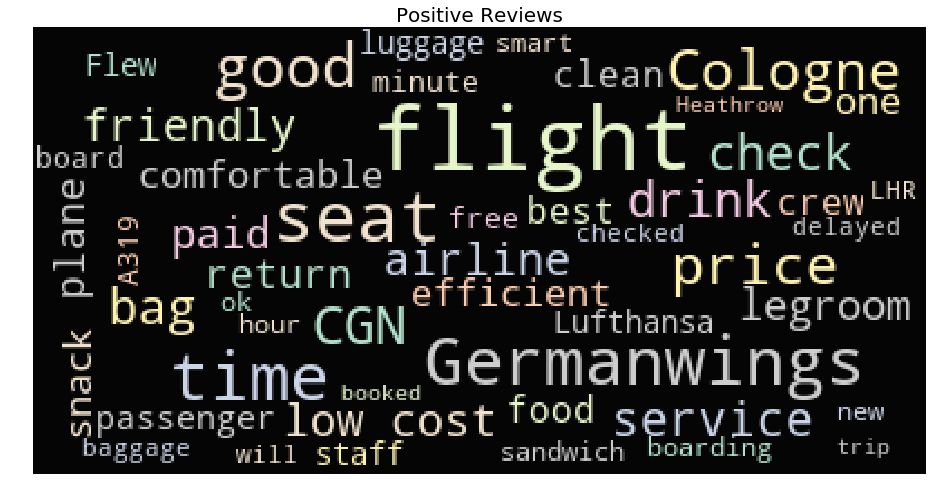

In [294]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", 
               max_words=50, 
               #mask=hcmask1, 
               stopwords=STOPWORDS, 
               max_font_size= 40
              )
wc.generate(" ".join(pos_review))

plt.title("Positive Reviews", fontsize=20)

# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)

plt.imshow(wc.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

[10:21:30] DEBUG update_title_pos
[10:21:30] DEBUG update_title_pos
[10:21:30] DEBUG update_title_pos
[10:21:30] DEBUG update_title_pos
[10:21:31] DEBUG update_title_pos


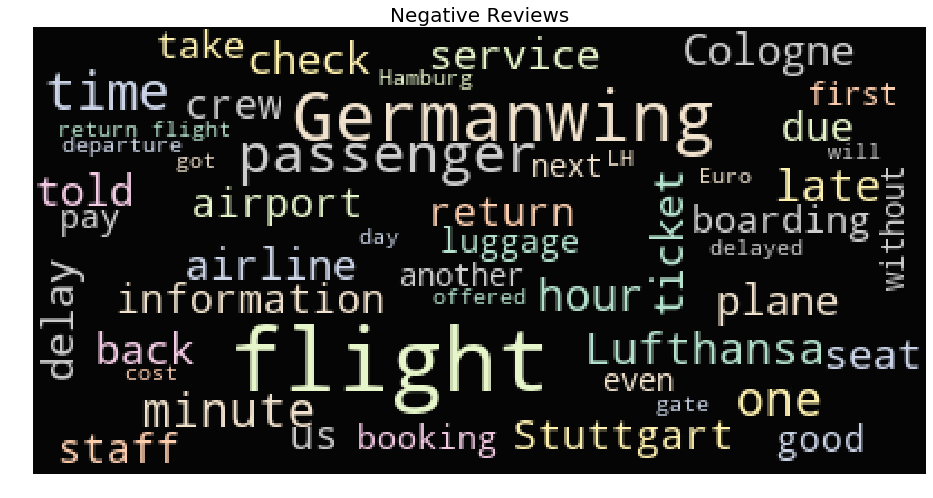

In [295]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", 
               max_words=50, 
               #mask=hcmask2, 
               stopwords=STOPWORDS, 
               max_font_size= 40
              )
wc.generate(" ".join(neg_review))

plt.title("Negative Reviews", fontsize=20)

# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)

plt.imshow(wc.recolor(colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

- ## 2.6 Topic Modeling 


One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.



**Reference**

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

- ### 2.6.1 Stemming and Lemmatization

The work at this stage attempts to reduce as many different variations of similar words into a single term ( different branches all reduced to single word stem). Therefore if we have "running", "runs" and "run", you would really want these three distinct words to collapse into just the word "run". (However of course you lose granularity of the past, present or future tense).


In [296]:
stemmer = nltk.stem.PorterStemmer()

In [297]:
print("The stemmed form of running is: {}".format(stemmer.stem("running")))
print("The stemmed form of runs is: {}".format(stemmer.stem("runs")))
print("The stemmed form of run is: {}".format(stemmer.stem("run")))

The stemmed form of running is: run
The stemmed form of runs is: run
The stemmed form of run is: run


We turn to another that we could use in lieu of stemming. 
This method is called lemmatization which aims to achieve the same effect as the former method. 
However unlike a stemmer, lemmatizing the dataset aims to reduce words based on an actual dictionary or vocabulary (the Lemma) and therefore will not chop off words into stemmed forms that do not carry any lexical meaning. 

Here we can utilize NLTK once again to initialize a lemmatizer (WordNet variant) and inspect how it collapses words as follows:

In [298]:
lemm = WordNetLemmatizer()
print("The lemmatized form of leaves is: {}".format(lemm.lemmatize("leaves")))

The lemmatized form of leaves is: leaf


In [299]:
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [309]:
def show_word_frequencies(text, num_words=50, title='Top 50 Word frequencies after Preprocessing'):
    tf_vectorizer = LemmaCountVectorizer(max_df=0.95, 
                                     min_df=2,
                                     stop_words='english',
                                     decode_error='ignore')
    tf = tf_vectorizer.fit_transform(text)

    feature_names = tf_vectorizer.get_feature_names()

    count_vec = np.asarray(tf.sum(axis=0)).ravel()

    zipped = list(zip(feature_names, count_vec))

    x, y = (list(x) for x in zip(*sorted(zipped, key=lambda x: x[1], reverse=True)))

    # Now I want to extract out on the top 15 and bottom 15 words
    Y = np.concatenate([y[0:15], y[-16:-1]])
    X = np.concatenate([x[0:15], x[-16:-1]])

    # Plotting the Plot.ly plot for the Top num_words word frequencies
    data = [go.Bar(x = x[0:num_words],
                   y = y[0:num_words],
                   marker= dict(colorscale='Jet',color = y[0:num_words]),
                   text='Word counts')]
    
    layout = go.Layout(title=title)

    fig = go.Figure(data=data, layout=layout)

    py.iplot(fig, filename='basic-bar')

    # Plotting the Plot.ly plot for the Top 50 word frequencies
    data = [go.Bar(x = x[-100:],
                   y = y[-100:],
                   marker= dict(colorscale='Portland',color = y[-100:]),
                   text='Word counts')]

In [310]:
text = list(df_review['Review'].values)
show_word_frequencies(text, title='Top 50 Word frequencies after Preprocessing')

In [311]:
pos_review = df_review[df_review['Recommended']=="yes"]["Review"].values
neg_review = df_review[df_review['Recommended']=="no"]["Review"].values

In [312]:
pos_text = list(pos_review)
show_word_frequencies(pos_text, title='Top 50 Word frequencies of positive reviews after Preprocessing')

In [313]:
neg_text = list(neg_review)
show_word_frequencies(neg_text, title='Top 50 Word frequencies of negative reviews after Preprocessing')

- ### 2.6.2 LDA

In natural language processing, latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model.


The latent Dirichlet allocation (LDA) algorithm first models documents via a mixture model of topics. 
From these topics, words are then assigned weights based on the probability distribution of these topics. 
It is this probabilistic assignment over words that allow a user of LDA to say how likely a particular word falls into a topic. 
Subsequently from the collection of words assigned to a particular topic, are we thus able to gain an insight as to what that topic may actually represent from a lexical point of view.


** Reference **

https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

https://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial

https://www.youtube.com/watch?v=3mHy4OSyRf0


In [314]:
lda = LatentDirichletAllocation(n_components=10, max_iter=5,
                                learning_method = 'online',
                                learning_offset = 50.,
                                random_state = 0)

In [315]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [316]:
# Define helper function to print top words
def print_top_words(model, feature_names, n_top_words):
    for index, topic in enumerate(model.components_):
        message = "\nTopic #{}:".format(index)
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1 :-1]])
        print(message)
        print("="*70)

In [318]:
n_top_words = 50
print("\nTopics in LDA model: ")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)


Topics in LDA model: 

Topic #0:fortunately main fare level probably collect 23kg buy online book organised clear ve plus choice bad view alliance 100 applied tell 05 gave twice emergency enter available march offer proper rude swift drink voucher went process week close 25 ended flown 2013 modern procedure 29 newspaper queue toilet recently funny

Topic #1:staff flight ham hour ticket germanwings airline route economy making based time checked arrived stuttgart just delay efficient able air passenger bus really delayed second advised extra 29th 900 expect wasn planned dusseldorf operator paid comfortable cologne error card member join cost included price modern home ground swiss vie disappointed

Topic #2:flight check seat time good cologne staff germanwings airline crew low cost minute friendly return cabin hour quite free ticket late ok passenger cheap lufthansa onboard delayed price bag want board plane extra booking short pay departure drink reasonably nice lh luggage efficient c

In [319]:
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]

In [320]:
first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]

[10:37:32] DEBUG update_title_pos
[10:37:32] DEBUG update_title_pos
[10:37:32] DEBUG update_title_pos
[10:37:32] DEBUG update_title_pos


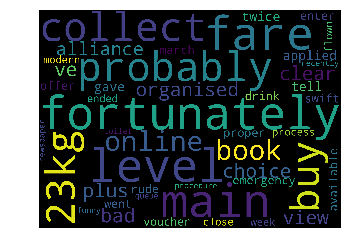

In [321]:
firstcloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500,
                       height=1800
                      ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

[10:38:39] DEBUG update_title_pos
[10:38:39] DEBUG update_title_pos
[10:38:39] DEBUG update_title_pos
[10:38:39] DEBUG update_title_pos


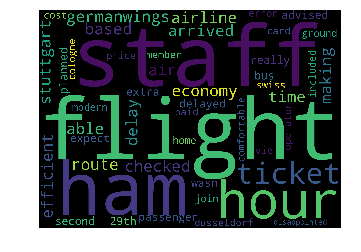

In [324]:
secondcloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500,
                       height=1800
                      ).generate(" ".join(second_topic_words))
plt.imshow(secondcloud)
plt.axis('off')
plt.show()

[10:38:53] DEBUG update_title_pos
[10:38:53] DEBUG update_title_pos
[10:38:53] DEBUG update_title_pos
[10:38:53] DEBUG update_title_pos


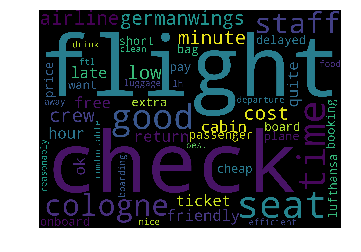

In [325]:
thirdcloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500,
                       height=1800
                      ).generate(" ".join(third_topic_words))
plt.imshow(thirdcloud)
plt.axis('off')
plt.show()

[10:39:05] DEBUG update_title_pos
[10:39:05] DEBUG update_title_pos
[10:39:05] DEBUG update_title_pos
[10:39:05] DEBUG update_title_pos


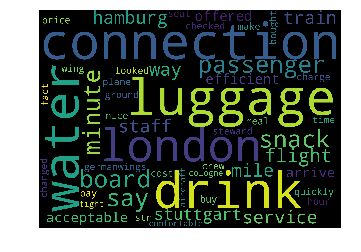

In [326]:
fourthcloud = WordCloud(stopwords=STOPWORDS,
                       background_color='black',
                       width=2500,
                       height=1800
                      ).generate(" ".join(fourth_topic_words))
plt.imshow(fourthcloud)
plt.axis('off')
plt.show()

#### TODO

visualizing the topics 

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

## 3. Modeling

The sentiment analysis problem is formulated into a binary classification problem, i.e., classify the text data (review) into recommended and non-recommended.

- Define evaluation metric
Kaggle has specified multi-class log-loss as evaluation metric.

The implementation is taken from: 

https://github.com/dnouri/nolearn/blob/master/nolearn/lasagne/util.py)

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

In [358]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

- Plot precision recall curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#sphx-glr-auto-examples-model-selection-plot-precision-recall-py

In [359]:
def plot_pr_curve(y_test, y_score, model_name, features):
    # calculate average precision score
    average_precision = average_precision_score(y_test, y_score)
    
    #print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    precision, recall, _ = precision_recall_curve(y_test, y_score)
    
    # calculate precision-recall AUC
    auc = sklearn.metrics.auc(recall, precision)
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}, AUC={1:0.2f}, model={2}, features={3}'.format(average_precision, 
                                                                                                           auc,
                                                                                                           model_name,
                                                                                                           features
                                                                                                            ))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    
    return auc, average_precision

- Plot AUC curve

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

https://qiita.com/bmj0114/items/460424c110a8ce22d945

In [360]:
def plot_auc_curve(y_test, y_score, model_name, features):
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    score = roc_auc_score(y_test, y_score)
    #roc_auc = sklearn.metrics.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: ROC_AUC_Score={0:0.2f}, model={1}, features={2}'.format(score,roc_auc,model_name,features))
    plt.legend(loc="lower right")
    plt.show()
    
    return score

- Prepare data sets

In [361]:
y = df_review['Recommended Label']

In [362]:
xtrain, xvalid, ytrain, yvalid = train_test_split(df_review['Review'].values, 
                                                  y, 
                                                  stratify=y, 
                                                  random_state=42, 
                                                  test_size=0.2, 
                                                  shuffle=True)

In [363]:
print (xtrain.shape)
print (xvalid.shape)

(101,)
(26,)


- #### TF-IDF


Tf means term-frequency while tf–idf means term-frequency times inverse document-frequency. For the details of tf-idf, we refer to

https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction

In [364]:
tfv = TfidfVectorizer(min_df=3,  
                      max_features=None, 
                      strip_accents='unicode', 
                      analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      use_idf=1,
                      smooth_idf=1,
                      sublinear_tf=1,
                      stop_words = 'english',
                     )

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(xtrain) + list(xvalid))
xtrain_tfv =  tfv.transform(xtrain) 
xvalid_tfv = tfv.transform(xvalid)

In [365]:
# Fitting a simple Logistic Regression on TFIDF
clf = LogisticRegression()
clf.fit(xtrain_tfv, ytrain)

predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

- #### Logloss

For a binary classification like our example, the typical loss function is the binary cross-entropy / log loss.

$$H_p(q) = - \frac{1}{N} \sum_{i=1}^{N} y_i \times log(p(y_i)) + (1-y_i) \times log(1-p(y_i))$$

Neural networks are trained using stochastic gradient descent and require that you choose a loss function when designing and configuring your model.

Given input, the model is trying to make predictions that match the data distribution of the target variable. Under maximum likelihood, a loss function estimates how closely the distribution of predictions made by a model matches the distribution of target variables in the training data.

**Cross-Entropy Loss** (or Log Loss)

Cross-entropy loss is often simply referred to as “cross-entropy,” “logarithmic loss,” “logistic loss,” or “log loss” for short.

Each predicted probability is compared to the actual class output value (0 or 1) and a score is calculated that penalizes the probability based on the distance from the expected value. The penalty is logarithmic, offering a small score for small differences (0.1 or 0.2) and enormous score for a large difference (0.9 or 1.0).

Cross-entropy loss is minimized, where smaller values represent a better model than larger values. A model that predicts perfect probabilities has a cross entropy or log loss of 0.0.

Cross-entropy for a binary or two class prediction problem is actually calculated as the average cross entropy across all examples.

Given a framework of maximum likelihood, we know that we want to use a cross-entropy or mean squared error loss function under stochastic gradient descent.

Nevertheless, we may or may not want to report the performance of the model using the loss function.

For example, logarithmic loss is challenging to interpret, especially for non-machine learning practitioner stakeholders. The same can be said for the mean squared error. Instead, it may be more important to report the accuracy and root mean squared error for models used for classification and regression respectively.

It may also be desirable to choose models based on these metrics instead of loss. This is an important consideration, as the model with the minimum loss may not be the model with best metric that is important to project stakeholders.

A good division to consider is to use the loss to evaluate and diagnose how well the model is learning. This includes all of the considerations of the optimization process, such as overfitting, underfitting, and convergence. An alternate metric can then be chosen that has meaning to the project stakeholders to both evaluate model performance and perform model selection.

The same metric can be used for both concerns but it is more likely that the concerns of the optimization process will differ from the goals of the project and different scores will be required. Nevertheless, it is often the case that improving the loss improves or, at worst, has no effect on the metric of interest.


**Reference**

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

https://medium.com/30-days-of-machine-learning/day-5-entropy-relative-entropy-and-cross-entropy-8369d67cc180

https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

In [366]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.611 


- #### Precision Recall curve

    - Precision-Recall curves summarize the trade-off between the **true positive rate** and the **positive predictive value** for a predictive model using different probability thresholds.
    - Precision-Recall curves are appropriate for imbalanced datasets, whereas ROC curves are appropriate when the observations are balanced between each class.

**Precision** is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is referred to as the positive predictive value.

$${Precision} = \frac{True Positives} {(True Positives + False Positives)}$$

**Recall** is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

$${Recall} = \frac{True Positives} {(True Positives + False Negatives)}$$

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, there are many examples of no event (class 0) and only a few examples of an event (class 1).

The reason for this is that typically the large number of class 0 examples means we are less interested in the skill of the model at predicting class 0 correctly, e.g. high true negatives.

There are also composite scores that attempt to summarize the precision and recall; three examples include:

- **F score** or **F1 score**: that calculates the harmonic mean of the precision and recall (harmonic mean because the precision and recall are ratios).

- **Average precision**: that summarizes the weighted increase in precision with each change in recall for the thresholds in the precision-recall curve.

- **Area Under Curve**: like the AUC, summarizes the integral or an approximation of the area under the precision-recall curve.

In terms of model selection, F1 summarizes model skill for a specific probability threshold, whereas average precision and area under curve summarize the skill of a model across thresholds, like ROC AUC.

This makes precision-recall and a plot of precision vs. recall and summary measures useful tools for binary classification problems that have an imbalance in the observations for each class.

The above explaination of Precision and Recall is taken from

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/



pr-auc: 0.8626614134324302
average precision: 0.8677735134331941
[18:01:00] DEBUG update_title_pos
[18:01:00] DEBUG update_title_pos
[18:01:00] DEBUG update_title_pos
[18:01:00] DEBUG update_title_pos
[18:01:00] DEBUG update_title_pos


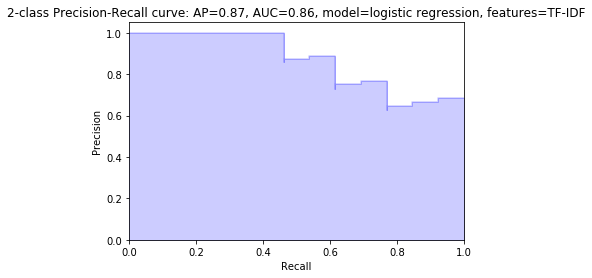

In [367]:
pr_auc, average_precision = plot_pr_curve(yvalid, predictions[:, 1], model_name='logistic regression', features='TF-IDF')

print('pr-auc: {}'.format(pr_auc))
print('average precision: {}'.format(average_precision))

In [368]:
print(classification_report(yvalid.values, ypred))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.71      0.77      0.74        13

   micro avg       0.73      0.73      0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



- #### ROC curve

    - ROC Curves summarize the trade-off between the **true positive rate** and **false positive rate** for a predictive model using different probability thresholds.
    
    - ROC curves are appropriate when the observations are balanced between each class, whereas precision-recall curves are appropriate for imbalanced datasets.
    
$${True Positive Rate} = \frac{True Positives} {(True Positives + False Negatives)}$$
The true positive rate is also referred to as sensitivity.

$${False Positive Rate} = \frac{False Positives} {(False Positives + True Negatives)}$$

The false positive rate is also referred to as the inverted specificity where specificity is the total number of true negatives divided by the sum of the number of true negatives and false positives.

$${Specificity} = \frac{True Negatives} {(True Negatives + False Positives)}$$

$${False Positive Rate} = 1 - {Specificity}$$

The ROC curve is a useful tool for a few reasons:

- The curves of different models can be compared directly in general or for different thresholds.
- The area under the curve (AUC) can be used as a summary of the model skill.


https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

[18:01:06] DEBUG update_title_pos
[18:01:06] DEBUG update_title_pos
[18:01:06] DEBUG update_title_pos
[18:01:06] DEBUG update_title_pos


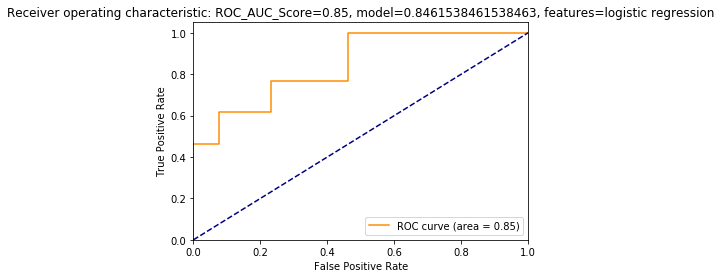

roc auc score: 0.8461538461538463


In [369]:
auc_score = plot_auc_curve(yvalid, predictions[:, 1], model_name='logistic regression',  features='TF-IDF')

print('roc auc score: {}'.format(auc_score))

- ### Put all the evaluation metrics in one function

In [370]:
def show_performance(yvalid, predictions, ypred, model_name, features):
    print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
    
    pr_auc, average_precision = plot_pr_curve(yvalid, predictions[:, 1], model_name=model_name, features=features)

    print('pr-auc: {}'.format(pr_auc))
    print('average precision: {}'.format(average_precision))
    
    print(classification_report(yvalid.values, ypred))

    auc_score = plot_auc_curve(yvalid, predictions[:, 1], model_name=model_name,  features=features)

    print('roc auc score: {}'.format(auc_score))

logloss: 0.611 
pr-auc: 0.8626614134324302
average precision: 0.8677735134331941
              precision    recall  f1-score   support

           0       0.75      0.69      0.72        13
           1       0.71      0.77      0.74        13

   micro avg       0.73      0.73      0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26

[18:01:14] DEBUG update_title_pos
[18:01:14] DEBUG update_title_pos
[18:01:14] DEBUG update_title_pos
[18:01:14] DEBUG update_title_pos


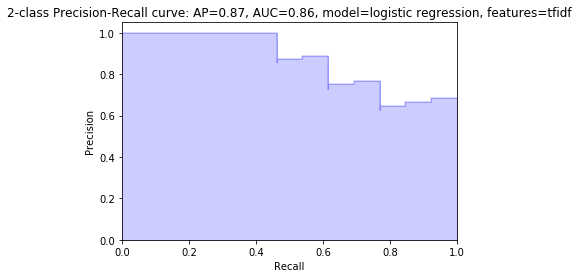

[18:01:14] DEBUG update_title_pos
[18:01:14] DEBUG update_title_pos
[18:01:14] DEBUG update_title_pos
[18:01:14] DEBUG update_title_pos


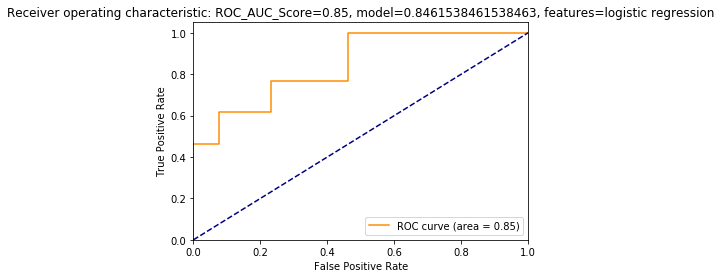

roc auc score: 0.8461538461538463


In [371]:
show_performance(yvalid, predictions, ypred, 'logistic regression', 'tfidf')

- Error analysis

In [372]:
def get_error_pred(yvalid, ypred):
    """
    Generate a dataframe contains the missclassified data
    """
    index_error = yvalid != ypred
    x_error = xvalid[index_error]
    ytrue_error = yvalid[index_error].values
    ypred_error = ypred[index_error]
    
    df_error = pd.DataFrame({'x':x_error, 'y_true':ytrue_error, 'y_pred':ypred_error})
    
    return df_error

In [373]:
def show_error_classification(yvalid, ypred):
    """
    Print the misclassified reviews
    """
    df_error = get_error_pred(yvalid, ypred)
    for index, row in df_error.iterrows():
        print('index: {}'.format(index))
        print(row['x'])
        print('true label: {}'.format(row['y_true']))
        print('\n')

In [374]:
show_error_classification(yvalid, ypred)

index: 0
Booked Lufthansa flight Cologne-Berlin on 28 Jan. On 2 Jan I got the information that the flight was operated by Germanwings a German low-cost carrier. So was the flight. Low cost: 1 hrs delayed for my beer I had to pay in Euros - cash. Lounge use was denied as the flight was operated under 4U code. No service for a high Lufthansa price. Not recommended very disappointed.
true label: 0


index: 1
First time I have used Germanwings for connecting flights (via Hamburg). The APP does not work properly. They are unable to issue both boarding cards on check in causing unnecessary inconvenience. Their Live Twitter response averages 24 hours to reply. Cabin crew spend most time behind front galley curtains. Also fail to do proper cabin secure checks prior to landing. Seats new ultra thin models OK for short flights. Seat pitch OK on the extra space seats. Smart fare snack boring and repetitive. They have taken over a lot of Lufthansa routes and to be honest they are not really geared

Review 2 is not clear for me it was positive or negative.

Reviews 4, 5 has some pros and cons.

Reviews 3, 6 could be neutral.

- #### Count Features

Convert a collection of text documents to a matrix of token counts. For more details, we refer to 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html



In [375]:
ctv = CountVectorizer(analyzer='word',
                      token_pattern=r'\w{1,}',
                      ngram_range=(1, 3), 
                      stop_words = 'english'
                     )

# Fitting Count Vectorizer to both training and test sets (semi-supervised learning)
ctv.fit(list(xtrain) + list(xvalid))

xtrain_ctv =  ctv.transform(xtrain) 
xvalid_ctv = ctv.transform(xvalid)

In [376]:
# Fitting a simple Logistic Regression on Counts
clf = LogisticRegression()
clf.fit(xtrain_ctv, ytrain)

predictions = clf.predict_proba(xvalid_ctv)
ypred = clf.predict(xvalid_ctv)

logloss: 0.553 
pr-auc: 0.7941346790596611
average precision: 0.8022438901100486
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.62      0.77      0.69        13

   micro avg       0.65      0.65      0.65        26
   macro avg       0.66      0.65      0.65        26
weighted avg       0.66      0.65      0.65        26

[18:03:05] DEBUG update_title_pos
[18:03:05] DEBUG update_title_pos
[18:03:05] DEBUG update_title_pos
[18:03:05] DEBUG update_title_pos


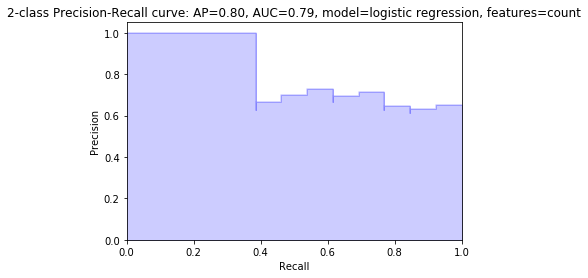

[18:03:05] DEBUG update_title_pos
[18:03:05] DEBUG update_title_pos
[18:03:05] DEBUG update_title_pos
[18:03:05] DEBUG update_title_pos


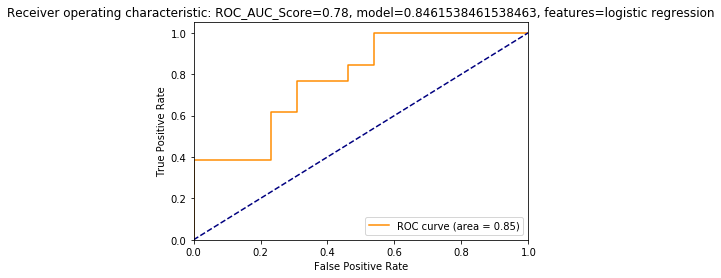

roc auc score: 0.7810650887573964


In [377]:
show_performance(yvalid, predictions, ypred, 'logistic regression', 'count')

It the tf-idf feature achieves better performance compared to the count features.

In [378]:
# Fitting a simple Naive Bayes on TFIDF
clf = MultinomialNB()
clf.fit(xtrain_tfv, ytrain)

predictions = clf.predict_proba(xvalid_tfv)
ypred = clf.predict(xvalid_tfv)

logloss: 0.556 
pr-auc: 0.8857951173353649
average precision: 0.8900704472685896
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.67      0.77      0.71        13

   micro avg       0.69      0.69      0.69        26
   macro avg       0.70      0.69      0.69        26
weighted avg       0.70      0.69      0.69        26

[18:05:31] DEBUG update_title_pos
[18:05:31] DEBUG update_title_pos
[18:05:31] DEBUG update_title_pos
[18:05:31] DEBUG update_title_pos


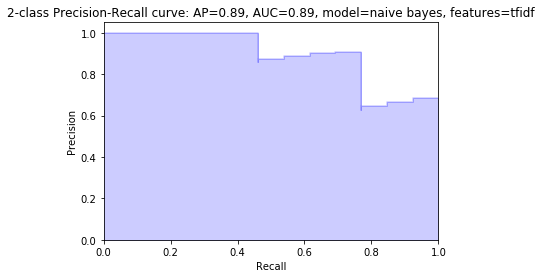

[18:05:31] DEBUG update_title_pos
[18:05:31] DEBUG update_title_pos
[18:05:31] DEBUG update_title_pos
[18:05:31] DEBUG update_title_pos


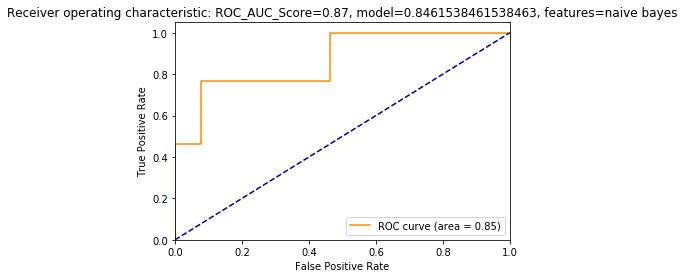

roc auc score: 0.8698224852071006


In [379]:
show_performance(yvalid, predictions, ypred, 'naive bayes', 'tfidf')

It shows that compared to logistic regression, naive bayes classifier achieves better performance.

In [380]:
# Fitting a simple Naive Bayes on Counts
clf = MultinomialNB()
clf.fit(xtrain_ctv, ytrain)

predictions = clf.predict_proba(xvalid_ctv)
ypred = clf.predict(xvalid_ctv)

logloss: 3.732 
pr-auc: 0.746112864140966
average precision: 0.7561423870247399
              precision    recall  f1-score   support

           0       1.00      0.31      0.47        13
           1       0.59      1.00      0.74        13

   micro avg       0.65      0.65      0.65        26
   macro avg       0.80      0.65      0.61        26
weighted avg       0.80      0.65      0.61        26

[18:06:45] DEBUG update_title_pos
[18:06:45] DEBUG update_title_pos
[18:06:45] DEBUG update_title_pos
[18:06:45] DEBUG update_title_pos


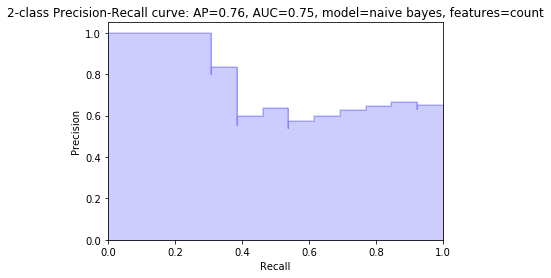

[18:06:45] DEBUG update_title_pos
[18:06:45] DEBUG update_title_pos
[18:06:45] DEBUG update_title_pos
[18:06:45] DEBUG update_title_pos


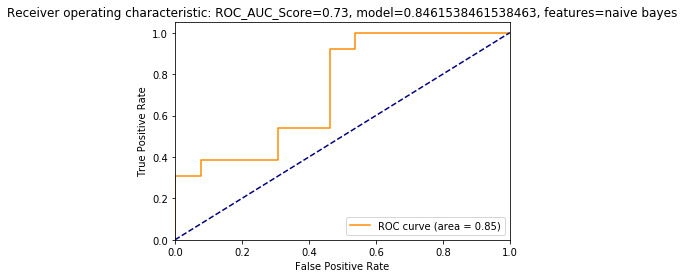

roc auc score: 0.7278106508875739


In [381]:
show_performance(yvalid, predictions, ypred, 'naive bayes', 'count')

By using the count features, the performance decreased.

- ### XGBoost


**Reference**

https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/

In [146]:
# Fitting a simple xgboost on tf-idf
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(xtrain_tfv.tocsc(), ytrain)

predictions = clf.predict_proba(xvalid_tfv.tocsc())
ypred = clf.predict(xvalid_tfv.tocsc())


In [152]:
# Fitting a simple xgboost on count features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(xtrain_ctv, ytrain)

predictions = clf.predict_proba(xvalid_ctv)
ypred = clf.predict(xvalid_ctv)

- #### Hyperparameter tuning


In [158]:
xgb_clf = xgb.XGBClassifier()

param_dist = {'learning_rate': [0.01, 0.05, 0.07], 
              'max_depth': [4, 6, 8],
              'n_estimators': [100, 200, 400],
              #'min_child_weight': [2, 4],
              #'silent': [1],
              #'subsample': [0.7],
              #'colsample_bytree': [0.7],
              #'nthread':[4], #when use hyperthread, xgboost may become slower
             }

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
# mll_scorer = metrics.make_scorer(multiclass_logloss, greater_is_better=False, needs_proba=True)
search = RandomizedSearchCV(estimator = xgb_clf, 
                            param_distributions = param_dist, 
                            n_jobs = 4,
                            verbose = 1,
                            cv = 3,
                            n_iter=20,
                            #scoring=mll_scorer,
                           )

search.fit(xtrain_tfv.tocsc(), ytrain)

print('xgboost (hyperparameter tuning with grid search)')
print(search.best_score_)
print(search.best_params_)

predictions = search.predict_proba(xvalid_tfv.tocsc())
ypred = search.predict(xvalid_tfv.tocsc())


Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.2s


xgboost (hyperparameter tuning with grid search)
0.7326732673267327
{'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.07}


[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:    3.2s finished


In [159]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.513 


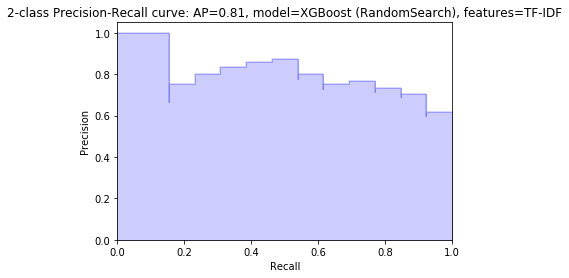

In [160]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='XGBoost (RandomSearch)', features='TF-IDF')

In [161]:
print(classification_report(yvalid.values, ypred))

              precision    recall  f1-score   support

           0       0.71      0.77      0.74        13
           1       0.75      0.69      0.72        13

   micro avg       0.73      0.73      0.73        26
   macro avg       0.73      0.73      0.73        26
weighted avg       0.73      0.73      0.73        26



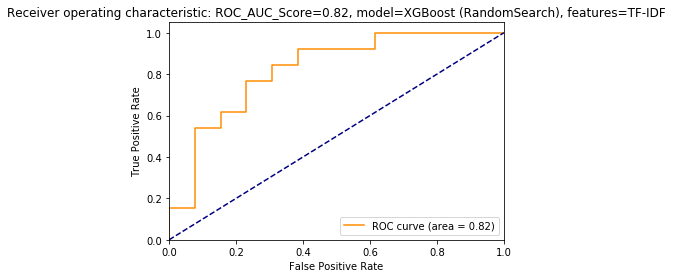

In [162]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='XGBoost (RandomSearch)',  features='TF-IDF')

In [163]:
roc_auc_score(yvalid, predictions[:, 1])

0.8224852071005917

It shows that random search hyperparameter tuning does not improve the performance.

- ### Word Embeddings 

Download the GloVe vectors from here 
http://www-nlp.stanford.edu/data/glove.840B.300d.zip


**Reference**

- Word embedding


https://machinelearningmastery.com/what-are-word-embeddings/


https://www.youtube.com/watch?v=5PL0TmQhItY


https://www.coursera.org/learn/nlp-sequence-models/home/week/2


- Glove embedding

https://www.kaggle.com/stacykurnikova/using-glove-embedding

https://www.quora.com/How-is-GloVe-different-from-word2vec


- Fast word embedding

https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings

https://spenai.org/bravepineapple/faster_em/


- NLP

https://www.kaggle.com/CVxTz/keras-bidirectional-lstm-baseline-lb-0-069

https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout

In [164]:
# load the GloVe vectors in a dictionary:

embeddings_index = {}
f = open('glove.6B.50d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

400000it [00:06, 57703.32it/s]

Found 400000 word vectors.


In [165]:
# this function creates a normalized vector for the whole sentence
def sent2vec(s):
    #stop_words = nltk.download('stopwords')
    #words = str(s).lower().decode('utf-8')
    words = str(s).lower()
    words = word_tokenize(words)
    words = [w for w in words if not w in stop_words]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(embeddings_index[w])
        except:
            continue
    M = np.array(M)
    v = M.sum(axis=0)
    if type(v) != np.ndarray:
        return np.zeros(300)
    return v / np.sqrt((v ** 2).sum())

In [166]:
# create sentence vectors using the above function for training and validation set

xtrain_glove = [sent2vec(x) for x in tqdm(xtrain)]
xvalid_glove = [sent2vec(x) for x in tqdm(xvalid)]

100%|██████████| 26/26 [00:00<00:00, 603.35it/s]


In [167]:
xtrain_glove = np.array(xtrain_glove)
xvalid_glove = np.array(xvalid_glove)

In [168]:
# Fitting a simple xgboost on glove features
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)

clf.fit(xtrain_glove, ytrain)

predictions = clf.predict_proba(xvalid_glove)
ypred = clf.predict(xvalid_glove)

In [169]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.918 


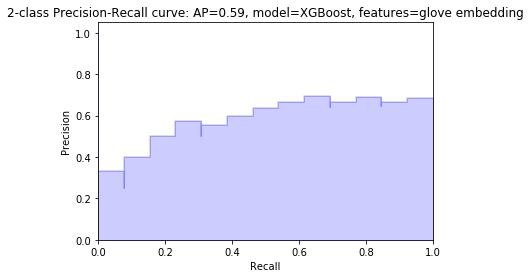

In [170]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='XGBoost', features='glove embedding')

In [171]:
print(classification_report(yvalid.values, ypred))

              precision    recall  f1-score   support

           0       0.64      0.69      0.67        13
           1       0.67      0.62      0.64        13

   micro avg       0.65      0.65      0.65        26
   macro avg       0.65      0.65      0.65        26
weighted avg       0.65      0.65      0.65        26



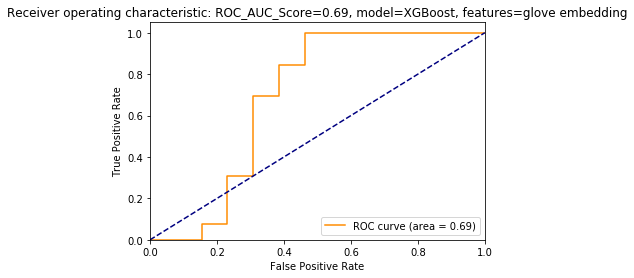

In [172]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='XGBoost',  features='glove embedding')

In [173]:
roc_auc_score(yvalid, predictions[:, 1])

0.6863905325443787

It shows that using xgboost with glove embedding features does not improve the performance.

- ### Deep Learning

In [174]:
# scale the data before any neural net:
scl = preprocessing.StandardScaler()
xtrain_glove_scl = scl.fit_transform(xtrain_glove)
xvalid_glove_scl = scl.transform(xvalid_glove)

In [175]:
xtrain_glove.shape

(101, 50)

In [176]:
# we need to binarize the labels for the neural net
ytrain_enc = np_utils.to_categorical(ytrain)
yvalid_enc = np_utils.to_categorical(yvalid)

In [177]:
ytrain_enc.shape

(101, 2)

In [178]:
yvalid_enc.shape

(26, 2)

In [179]:
xtrain_glove.shape[1]

50

In [180]:
# create a simple 3 layer sequential neural net
model = Sequential()

model.add(Dense(300, input_dim=xtrain_glove.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(2))
model.add(Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [181]:
model.fit(xtrain_glove_scl, y=ytrain_enc, batch_size=64, 
          epochs=10, verbose=1, 
          #validation_data=(xvalid_glove_scl, yvalid_enc)
         )

Epoch 1/10
101/101 [==============================] - 1s 7ms/step - loss: 0.9617
Epoch 2/10
101/101 [==============================] - 0s 103us/step - loss: 0.5669
Epoch 3/10
101/101 [==============================] - 0s 91us/step - loss: 0.5032
Epoch 4/10
101/101 [==============================] - 0s 95us/step - loss: 0.4104
Epoch 5/10
101/101 [==============================] - 0s 92us/step - loss: 0.3056
Epoch 6/10
101/101 [==============================] - 0s 92us/step - loss: 0.2958
Epoch 7/10
101/101 [==============================] - 0s 92us/step - loss: 0.2316
Epoch 8/10
101/101 [==============================] - 0s 88us/step - loss: 0.1304
Epoch 9/10
101/101 [==============================] - 0s 90us/step - loss: 0.1458
Epoch 10/10
101/101 [==============================] - 0s 94us/step - loss: 0.1297


In [182]:
predictions = model.predict(xvalid_glove_scl)

In [183]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.859 


In [184]:
ypred = predictions.argmax(axis=-1)

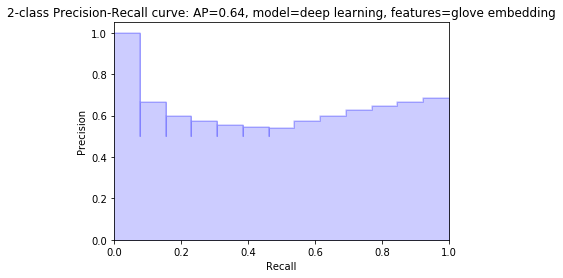

In [185]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='deep learning', features='glove embedding')

In [186]:
print(classification_report(yvalid.values, ypred))

              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.62      0.77      0.69        13

   micro avg       0.65      0.65      0.65        26
   macro avg       0.66      0.65      0.65        26
weighted avg       0.66      0.65      0.65        26



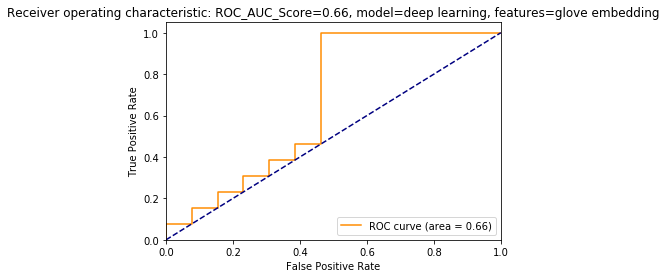

In [187]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='deep learning',  features='glove embedding')

In [188]:
roc_auc_score(yvalid, predictions[:, 1])

0.6627218934911242

- #### LSTM

https://www.coursera.org/learn/nlp-sequence-models/lecture/KXoay/long-short-term-memory-lstm

In [189]:
# using keras tokenizer here
token = keras.preprocessing.text.Tokenizer(num_words=None)
max_len = 70

token.fit_on_texts(list(xtrain) + list(xvalid))
xtrain_seq = token.texts_to_sequences(xtrain)
xvalid_seq = token.texts_to_sequences(xvalid)

# zero pad the sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)
xvalid_pad = sequence.pad_sequences(xvalid_seq, maxlen=max_len)

word_index = token.word_index

In [190]:
# create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, xtrain_glove.shape[1]))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 2152/2152 [00:00<00:00, 347989.14it/s]


In [191]:
embedding_matrix.shape

(2153, 50)

In [192]:
len(word_index) + 1

2153

In [193]:
# LSTM with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(5, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [194]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=200, verbose=0, 
          callbacks=[earlystop],
          #validation_data=(xvalid_pad, yvalid_enc)
         )

In [195]:
predictions = model.predict(xvalid_pad)

In [196]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.643 


In [197]:
ypred = predictions.argmax(axis=-1)

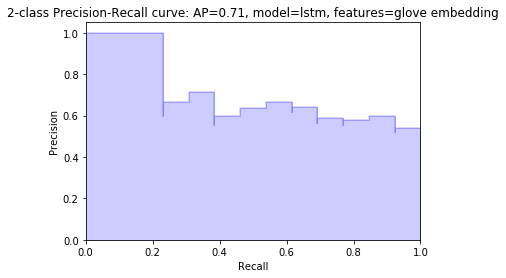

In [198]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='lstm', features='glove embedding')

In [199]:
print(classification_report(yvalid.values, ypred))

              precision    recall  f1-score   support

           0       0.64      0.54      0.58        13
           1       0.60      0.69      0.64        13

   micro avg       0.62      0.62      0.62        26
   macro avg       0.62      0.62      0.61        26
weighted avg       0.62      0.62      0.61        26



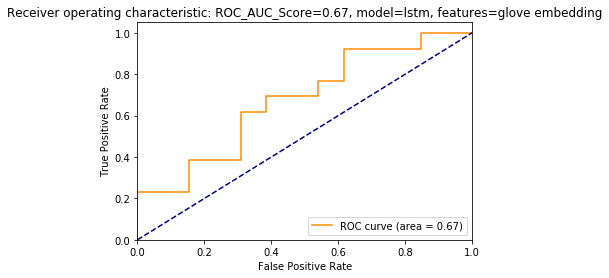

In [200]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='lstm',  features='glove embedding')

In [201]:
roc_auc_score(yvalid, predictions[:, 1])

0.6745562130177515

- #### GRU

https://www.coursera.org/learn/nlp-sequence-models/lecture/agZiL/gated-recurrent-unit-gru

In [202]:
# GRU with glove embeddings and two dense layers
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(GRU(5, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [203]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, epochs=200, 
          verbose=0, 
          callbacks=[earlystop],
          #validation_data=(xvalid_pad, yvalid_enc), 
         )

In [204]:
predictions = model.predict(xvalid_pad)

In [205]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.711 


In [206]:
ypred = predictions.argmax(axis=-1)

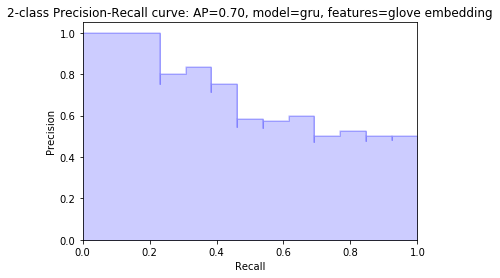

In [207]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='gru', features='glove embedding')

In [208]:
print(classification_report(yvalid.values, ypred))

              precision    recall  f1-score   support

           0       0.58      0.54      0.56        13
           1       0.57      0.62      0.59        13

   micro avg       0.58      0.58      0.58        26
   macro avg       0.58      0.58      0.58        26
weighted avg       0.58      0.58      0.58        26



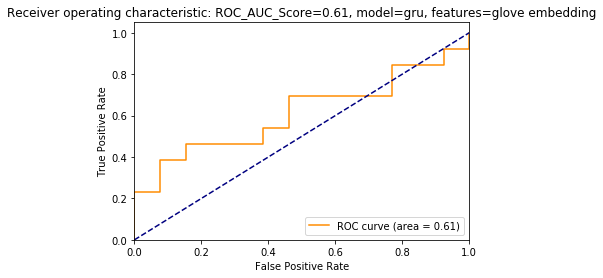

In [209]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='gru',  features='glove embedding')

In [210]:
roc_auc_score(yvalid, predictions[:, 1])

0.6094674556213018

- #### Bi-directional LSTM

https://www.coursera.org/learn/nlp-sequence-models/lecture/fyXnn/bidirectional-rnn

In [211]:
# A simple bidirectional LSTM with glove embeddings and two dense layers
model = Sequential()

model.add(Embedding(len(word_index) + 1,
                     embedding_matrix.shape[1],
                     weights=[embedding_matrix],
                     input_length=max_len,
                     trainable=False))

model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(5, dropout=0.3, recurrent_dropout=0.3)))

model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=ytrain_enc, batch_size=512, 
          epochs=200, 
          verbose=0, 
          callbacks=[earlystop]
          #validation_data=(xvalid_pad, yvalid_enc), 
         )

In [212]:
predictions = model.predict(xvalid_pad)

In [213]:
print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))

logloss: 0.665 


In [214]:
ypred = predictions.argmax(axis=-1)

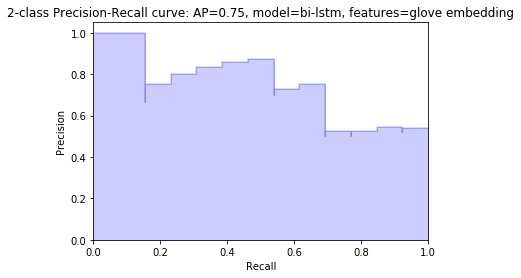

In [215]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='bi-lstm', features='glove embedding')

In [216]:
print(classification_report(yvalid.values, ypred))

              precision    recall  f1-score   support

           0       0.62      0.77      0.69        13
           1       0.70      0.54      0.61        13

   micro avg       0.65      0.65      0.65        26
   macro avg       0.66      0.65      0.65        26
weighted avg       0.66      0.65      0.65        26



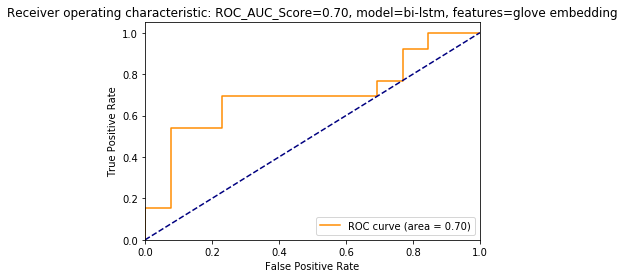

In [217]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='bi-lstm',  features='glove embedding')

In [218]:
roc_auc_score(yvalid, predictions[:, 1])

0.6982248520710058

- ### Ensembling

TODO: test the function

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle


In [219]:
logging.basicConfig(
    level=logging.DEBUG,
    format="[%(asctime)s] %(levelname)s %(message)s",
    datefmt="%H:%M:%S", stream=sys.stdout)
logger = logging.getLogger(__name__)


class Ensembler(object):
    def __init__(self, model_dict, num_folds=3, task_type='classification', optimize=roc_auc_score,
                 lower_is_better=False, save_path=None):
        """
        Ensembler init function
        :param model_dict: model dictionary, see README for its format
        :param num_folds: the number of folds for ensembling
        :param task_type: classification or regression
        :param optimize: the function to optimize for, e.g. AUC, logloss, etc. Must have two arguments y_test and y_pred
        :param lower_is_better: is lower value of optimization function better or higher
        :param save_path: path to which model pickles will be dumped to along with generated predictions, or None
        """

        self.model_dict = model_dict
        self.levels = len(self.model_dict)
        self.num_folds = num_folds
        self.task_type = task_type
        self.optimize = optimize
        self.lower_is_better = lower_is_better
        self.save_path = save_path

        self.training_data = None
        self.test_data = None
        self.y = None
        self.lbl_enc = None
        self.y_enc = None
        self.train_prediction_dict = None
        self.test_prediction_dict = None
        self.num_classes = None

    def fit(self, training_data, y, lentrain):
        """
        :param training_data: training data in tabular format
        :param y: binary, multi-class or regression
        :return: chain of models to be used in prediction
        """

        self.training_data = training_data
        self.y = y

        if self.task_type == 'classification':
            self.num_classes = len(np.unique(self.y))
            logger.info("Found %d classes", self.num_classes)
            self.lbl_enc = preprocessing.LabelEncoder()
            self.y_enc = self.lbl_enc.fit_transform(self.y)
            kf = StratifiedKFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, self.num_classes)
        else:
            self.num_classes = -1
            self.y_enc = self.y
            kf = KFold(n_splits=self.num_folds)
            train_prediction_shape = (lentrain, 1)

        self.train_prediction_dict = {}
        for level in range(self.levels):
            self.train_prediction_dict[level] = np.zeros((train_prediction_shape[0],
                                                          train_prediction_shape[1] * len(self.model_dict[level])))

        for level in range(self.levels):

            if level == 0:
                temp_train = self.training_data
            else:
                temp_train = self.train_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):
                validation_scores = []
                foldnum = 1
                for train_index, valid_index in kf.split(self.train_prediction_dict[0], self.y_enc):
                    logger.info("Training Level %d Fold # %d. Model # %d", level, foldnum, model_num)

                    if level != 0:
                        l_training_data = temp_train[train_index]
                        l_validation_data = temp_train[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])
                    else:
                        l0_training_data = temp_train[0][model_num]
                        if type(l0_training_data) == list:
                            l_training_data = [x[train_index] for x in l0_training_data]
                            l_validation_data = [x[valid_index] for x in l0_training_data]
                        else:
                            l_training_data = l0_training_data[train_index]
                            l_validation_data = l0_training_data[valid_index]
                        model.fit(l_training_data, self.y_enc[train_index])

                    logger.info("Predicting Level %d. Fold # %d. Model # %d", level, foldnum, model_num)

                    if self.task_type == 'classification':
                        temp_train_predictions = model.predict_proba(l_validation_data)
                        self.train_prediction_dict[level][valid_index,
                        (model_num * self.num_classes):(model_num * self.num_classes) +
                                                       self.num_classes] = temp_train_predictions

                    else:
                        temp_train_predictions = model.predict(l_validation_data)
                        self.train_prediction_dict[level][valid_index, model_num] = temp_train_predictions
                    validation_score = self.optimize(self.y_enc[valid_index], temp_train_predictions)
                    validation_scores.append(validation_score)
                    logger.info("Level %d. Fold # %d. Model # %d. Validation Score = %f", level, foldnum, model_num,
                                validation_score)
                    foldnum += 1
                avg_score = np.mean(validation_scores)
                std_score = np.std(validation_scores)
                logger.info("Level %d. Model # %d. Mean Score = %f. Std Dev = %f", level, model_num,
                            avg_score, std_score)

            logger.info("Saving predictions for level # %d", level)
            train_predictions_df = pd.DataFrame(self.train_prediction_dict[level])
            train_predictions_df.to_csv(os.path.join(self.save_path, "train_predictions_level_" + str(level) + ".csv"),
                                        index=False, header=None)

        return self.train_prediction_dict

    def predict(self, test_data, lentest):
        self.test_data = test_data
        if self.task_type == 'classification':
            test_prediction_shape = (lentest, self.num_classes)
        else:
            test_prediction_shape = (lentest, 1)

        self.test_prediction_dict = {}
        for level in range(self.levels):
            self.test_prediction_dict[level] = np.zeros((test_prediction_shape[0],
                                                         test_prediction_shape[1] * len(self.model_dict[level])))
        self.test_data = test_data
        for level in range(self.levels):
            if level == 0:
                temp_train = self.training_data
                temp_test = self.test_data
            else:
                temp_train = self.train_prediction_dict[level - 1]
                temp_test = self.test_prediction_dict[level - 1]

            for model_num, model in enumerate(self.model_dict[level]):

                logger.info("Training Fulldata Level %d. Model # %d", level, model_num)
                if level == 0:
                    model.fit(temp_train[0][model_num], self.y_enc)
                else:
                    model.fit(temp_train, self.y_enc)

                logger.info("Predicting Test Level %d. Model # %d", level, model_num)

                if self.task_type == 'classification':
                    if level == 0:
                        temp_test_predictions = model.predict_proba(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict_proba(temp_test)
                    self.test_prediction_dict[level][:, (model_num * self.num_classes): (model_num * self.num_classes) +
                                                                                        self.num_classes] = temp_test_predictions

                else:
                    if level == 0:
                        temp_test_predictions = model.predict(temp_test[0][model_num])
                    else:
                        temp_test_predictions = model.predict(temp_test)
                    self.test_prediction_dict[level][:, model_num] = temp_test_predictions

            test_predictions_df = pd.DataFrame(self.test_prediction_dict[level])
            test_predictions_df.to_csv(os.path.join(self.save_path, "test_predictions_level_" + str(level) + ".csv"),
                                       index=False, header=None)

        return self.test_prediction_dict

In [220]:
# specify the data to be used for every level of ensembling:
train_data_dict = {0: [xtrain_tfv, xtrain_ctv, xtrain_tfv, xtrain_ctv], 1: [xtrain_glove]}
test_data_dict = {0: [xvalid_tfv, xvalid_ctv, xvalid_tfv, xvalid_ctv], 1: [xvalid_glove]}

model_dict = {0: [LogisticRegression(), LogisticRegression(), MultinomialNB(alpha=0.1), MultinomialNB()],

              1: [xgb.XGBClassifier(silent=True, n_estimators=120, max_depth=7)]}

ens = Ensembler(model_dict=model_dict, num_folds=3, task_type='classification',
                optimize=multiclass_logloss, lower_is_better=True, save_path='')

ens.fit(train_data_dict, ytrain, lentrain=xtrain_glove.shape[0])
preds = ens.predict(test_data_dict, lentest=xvalid_glove.shape[0])


[20:36:21] INFO Found 2 classes
[20:36:21] INFO Training Level 0 Fold # 1. Model # 0
[20:36:21] INFO Predicting Level 0. Fold # 1. Model # 0
[20:36:21] INFO Level 0. Fold # 1. Model # 0. Validation Score = 0.628011
[20:36:21] INFO Training Level 0 Fold # 2. Model # 0
[20:36:21] INFO Predicting Level 0. Fold # 2. Model # 0
[20:36:21] INFO Level 0. Fold # 2. Model # 0. Validation Score = 0.636806
[20:36:21] INFO Training Level 0 Fold # 3. Model # 0
[20:36:21] INFO Predicting Level 0. Fold # 3. Model # 0
[20:36:21] INFO Level 0. Fold # 3. Model # 0. Validation Score = 0.634342
[20:36:21] INFO Level 0. Model # 0. Mean Score = 0.633053. Std Dev = 0.003704
[20:36:21] INFO Training Level 0 Fold # 1. Model # 1
[20:36:21] INFO Predicting Level 0. Fold # 1. Model # 1
[20:36:21] INFO Level 0. Fold # 1. Model # 1. Validation Score = 0.515345
[20:36:21] INFO Training Level 0 Fold # 2. Model # 1
[20:36:21] INFO Predicting Level 0. Fold # 2. Model # 1
[20:36:21] INFO Level 0. Fold # 2. Model # 1. Val

In [221]:
multiclass_logloss(yvalid, preds[1])

0.6093903354243129

[20:36:21] DEBUG update_title_pos
[20:36:21] DEBUG update_title_pos
[20:36:21] DEBUG update_title_pos
[20:36:21] DEBUG update_title_pos
[20:36:21] DEBUG update_title_pos


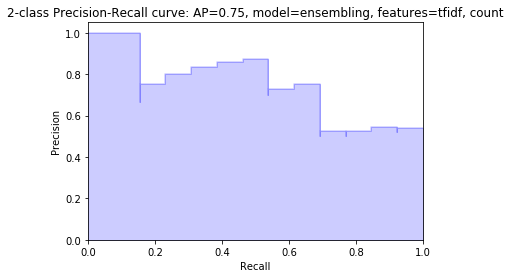

In [222]:
plot_pr_curve(yvalid, predictions[:, 1], model_name='ensembling', features='tfidf, count')

In [223]:
ypred = predictions.argmax(axis=-1)

In [224]:
print(classification_report(yvalid.values, ypred))

              precision    recall  f1-score   support

           0       0.62      0.77      0.69        13
           1       0.70      0.54      0.61        13

   micro avg       0.65      0.65      0.65        26
   macro avg       0.66      0.65      0.65        26
weighted avg       0.66      0.65      0.65        26



[20:36:22] DEBUG update_title_pos
[20:36:22] DEBUG update_title_pos
[20:36:22] DEBUG update_title_pos
[20:36:22] DEBUG update_title_pos


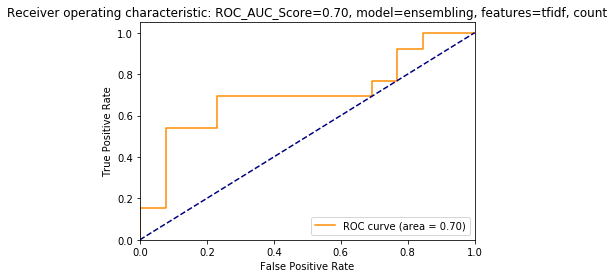

In [225]:
plot_auc_curve(yvalid, predictions[:, 1], model_name='ensembling',  features='tfidf, count')

In [226]:
roc_auc_score(yvalid, predictions[:, 1])

0.6982248520710058

## Future work

- **Topic modeling**
    - Have a deeper understanding about LDA

- ** Knowledge Graph **


- **Getting more data**
    - Get review data from other flight companies
    - Generate text data with neural networks

- **Sentiment analysis with deep learning**
    - Try different neural network architectures, e.g., BERT (https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d)
    
- **Word embedding**
    - Try other word embedding algorithms, e.g., fastText (https://fasttext.cc/)

- **Ensembling**

## More Topic Modeling

The following code is adapted from 

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [227]:
# python3 -m spacy download en

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

from pprint import pprint

import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

[20:36:22] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


- ### Clean up the text

In [228]:
# Convert to list
data = df_review['Review'].values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['We flew with Germanwings (or tried to) on September 30th. After two lengthy '
 'delays passengers were notified that the flight was cancelled and to return '
 'to the check-in counter for further information. After waiting at the '
 'counter for another 30 minutes or so, staff began issuing refunds or '
 'providing alternate travel options to passengers. By this point it was quite '
 'late in the evening with limited options (plus we were 5+ hours after '
 'planned departure). We managed to get a voucher with 3 other passenger to '
 'get a flight from Stuttgart to Zurich with an ongoing connection to '
 'Amsterdam (flights were with Swiss). We made the flight and the connector '
 '(which was held back waiting for about 70 of us) however luggage did not '
 'make it. Short of this is the airline was ill-prepared to manage this. They '
 'offered little information or options to passengers. since returning home I '
 'have been attempting to contact them via email and phone calls to discu

- ### Tokenize

Tokenize and Clean-up using gensim’s simple_preprocess().

Tokenize each sentence into a list of words, removing punctuations and unnecessary characters altogether.

In [229]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['we', 'flew', 'with', 'germanwings', 'or', 'tried', 'to', 'on', 'september', 'th', 'after', 'two', 'lengthy', 'delays', 'passengers', 'were', 'notified', 'that', 'the', 'flight', 'was', 'cancelled', 'and', 'to', 'return', 'to', 'the', 'check', 'in', 'counter', 'for', 'further', 'information', 'after', 'waiting', 'at', 'the', 'counter', 'for', 'another', 'minutes', 'or', 'so', 'staff', 'began', 'issuing', 'refunds', 'or', 'providing', 'alternate', 'travel', 'options', 'to', 'passengers', 'by', 'this', 'point', 'it', 'was', 'quite', 'late', 'in', 'the', 'evening', 'with', 'limited', 'options', 'plus', 'we', 'were', 'hours', 'after', 'planned', 'departure', 'we', 'managed', 'to', 'get', 'voucher', 'with', 'other', 'passenger', 'to', 'get', 'flight', 'from', 'stuttgart', 'to', 'zurich', 'with', 'an', 'ongoing', 'connection', 'to', 'amsterdam', 'flights', 'were', 'with', 'swiss', 'we', 'made', 'the', 'flight', 'and', 'the', 'connector', 'which', 'was', 'held', 'back', 'waiting', 'for', 'a

- ### Lemmatization

Lemmatization is a process where we convert words to its root word.

For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.

The advantage of this is, we get to reduce the total number of unique words in the dictionary. 

As a result, the number of columns in the document-word matrix (created by CountVectorizer in the next step) will be denser with lesser columns.

You can expect better topics to be generated in the end.

In [230]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' 
                                   for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', 
                 disable=['parser', 'ner']
                )

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['fly germanwing try september lengthy delay passenger be notify flight be cancel return check counter further information wait counter minute so staff begin issue refund provide alternate travel option passenger point be quite late evening limited option be hour plan departure manage get vouch other passenger get flight stuttgart zurich ongoing connection amsterdam flight be swiss make flight connector which be hold wait however luggage do not make short be airline be ill prepared manage offer little information option passenger return home have be attempt contact email phone call discuss compensation passenger right brochure have be unresponsive not good way run business', 'be less impressed germanwing service say least  first connection hamburg stewardess have tell could have water free everything have be charge  second connection hamburg london be refuse water be pregnant not feel well find disgust fact passenger will not be offer water be unwell will not be look way needless say s

- ### Create the Document-Word matrix

The LDA topic model algorithm requires a document word matrix as the main input.

The below code configured the CountVectorizer to consider words that has occurred at least 10 times (min_df), 
remove built-in english stopwords, convert all words to lowercase, 
and a word can contain numbers and alphabets of at least length 3 in order to be qualified as a word.


In [231]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

- ### Check the Sparsicity

Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.


In [232]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  16.76571088991235 %


- ### Build LDA model with sklearn

In [233]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=5,                # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=42,           # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = 4,                # Use 4 available CPUs
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=4, n_topics=5, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


- ### Diagnose model performance with perplexity and log-likelihood

A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

In [234]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())


Log Likelihood:  -14002.570972577021
Perplexity:  104.79613950362412
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': 4,
 'n_topics': 5,
 'perp_tol': 0.1,
 'random_state': 42,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


- ### Use GridSearch to find the best LDA model?

The most important tuning parameter for LDA models is n_components (number of topics). 

In addition, I am going to search learning_decay (which controls the learning rate) as well.

Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.


In [235]:
# Define Search Param
search_params = {'n_components': [2, 4, 6, 8, 10], 
                 'learning_decay': [.5, .7, .9]
                }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [2, 4, 6, 8, 10], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

- ### Show the best topic model and its parameters

In [236]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 2}
Best Log Likelihood Score:  -4790.270220318473
Model Perplexity:  88.99666388188935


The result shows that for LDA the best number of topics is 2. I believe the two topics would be positive review and negative review.

- ### Show the dominant topic in each document

In [237]:
# Create Document - Topic Matrix
#lda_output = lda_model.transform(data_vectorized)
lda_output = best_lda_model.transform(data_vectorized)

# column names
#topicnames = ["Topic" + str(i) for i in range(lda_model.n_topics)]
topicnames = ["Topic" + str(i) for i in range(2)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,dominant_topic
Doc0,0.03,0.97,1
Doc1,0.04,0.96,1
Doc2,0.22,0.78,1
Doc3,0.62,0.38,0
Doc4,0.03,0.97,1
Doc5,0.22,0.78,1
Doc6,0.78,0.22,0
Doc7,0.22,0.78,1
Doc8,0.19,0.81,1
Doc9,0.9,0.1,0


- ### Review topics distribution across documents

In [238]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,64
1,1,63


- ### Visualize the LDA model with pyLDAvis

The pyLDAvis offers the best visualization to view the topics-keywords distribution.

**TODO** : have a deep understanding of the visualization.

In [239]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
0     -60.312317  141.369629       1        1  51.272792
1      60.312561 -141.369141       2        1  48.727208, topic_info=    Category        Freq         Term       Total  loglift  logprob
80   Default   39.000000        price   39.000000  30.0000  30.0000
95   Default   32.000000         tell   32.000000  29.0000  29.0000
66   Default   40.000000    lufthansa   40.000000  28.0000  28.0000
48   Default   74.000000         good   74.000000  27.0000  27.0000
14   Default   28.000000        cabin   28.000000  26.0000  26.0000
52   Default   43.000000         hour   43.000000  25.0000  25.0000
2    Default   26.000000      airport   26.000000  24.0000  24.0000
65   Default   27.000000          low   27.000000  23.0000  23.0000
27   Default   47.000000         crew   47.000000  22.0000  22.0000
44   Default   30.000000     friendly   30.000000  21.0000  21.0000
76   Default   54.000000    passenger   54.000000  20.0000  20.0000
94   Default   22.000000    stuttgart   22.000000  19.0000  19.0000
26   Default   33.000000         cost   33.000000  18.0000  18.0000
54   Default   21.000000  information   21.000000  17.0000  17.0000
18   Default   19.000000       charge   19.000000  16.0000  16.0000
29   Default   57.000000        delay   57.000000  15.0000  15.0000
25   Default   21.000000  comfortable   21.000000  14.0000  14.0000
91   Default   20.000000        smart   20.000000  13.0000  13.0000
33   Default   20.000000    efficient   20.000000  12.0000  12.0000
22   Default   19.000000        clean   19.000000  11.0000  11.0000
103  Default   21.000000         wait   21.000000  10.0000  10.0000
60   Default   22.000000      legroom   22.000000   9.0000   9.0000
81   Default   17.000000      problem   17.000000   8.0000   8.0000
84   Default   54.000000       return   54.000000   7.0000   7.0000
70   Default   40.000000       minute   40.000000   6.0000   6.0000
15   Default   14.000000       cancel   14.000000   5.0000   5.0000
16   Default   15.000000      carrier   15.000000   4.0000   4.0000
99   Default   18.000000         trip   18.000000   3.0000   3.0000
86   Default   20.000000     sandwich   20.000000   2.0000   2.0000
67   Default   32.000000      luggage   32.000000   1.0000   1.0000
..       ...         ...          ...         ...      ...      ...
6     Topic2   24.267235          bag   30.152619   0.5018  -4.1016
56    Topic2    9.338731         land   11.670803   0.4960  -5.0566
67    Topic2   25.601045      luggage   32.092986   0.4929  -4.0481
70    Topic2   32.129676       minute   40.835909   0.4792  -3.8210
29    Topic2   44.900942        delay   57.359727   0.4740  -3.4863
37    Topic2   12.817245        extra   16.524803   0.4649  -4.7400
84    Topic2   40.702323       return   54.402115   0.4288  -3.5845
49    Topic2   11.466356       ground   15.539974   0.4149  -4.8513
71    Topic2   10.722843         need   14.568150   0.4125  -4.9184
64    Topic2    7.829280         look   10.682579   0.4082  -5.2329
73    Topic2   11.351144         nice   15.537507   0.4050  -4.8614
57    Topic2   26.517867         late   36.892134   0.3888  -4.0129
4     Topic2   16.732109       arrive   23.299952   0.3878  -4.4734
50    Topic2   11.057333      hamburg   15.531216   0.3792  -4.8877
46    Topic2   12.419893       german   17.472198   0.3776  -4.7715
58    Topic2   16.847747        leave   24.258332   0.3544  -4.4665
47    Topic2   61.053585   germanwing   99.765340   0.2279  -3.1790
77    Topic2   30.395335          pay   47.490097   0.2727  -3.8765
40    Topic2  120.758685       flight  240.605653   0.0296  -2.4970
20    Topic2   37.897679        check   67.724710   0.1384  -3.6559
41    Topic2   32.422492          fly   56.136633   0.1700  -3.8119
78    Topic2   22.376918        plane   39.671178   0.1463  -4.1827
97    Topic2   34.197387         time   78.160416  -0.107

- ### Show the Topic’s keywords?

The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.



In [240]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
print(df_topic_keywords.head())

         aircraft   airline    airport   arrival     arrive       bad  \
Topic0  13.951743  22.27163   0.759309  8.064817   6.870823  4.467957   
Topic1   2.048257  22.72837  26.240691  6.935183  17.129177  6.532043   

              bag   baggage     berlin      board  ...     ticket       time  \
Topic0   6.156881  6.010166   8.689037  20.287434  ...  17.138386  45.991078   
Topic1  24.843119  8.989834  13.310963  19.712566  ...  16.861614  35.008922   

          travel       trip        try        use      value       wait  \
Topic0  6.947248  17.812279   0.725465  23.880051  11.602792   1.883094   
Topic1  8.052752   1.187721  12.274535   7.119949   1.397208  20.116906   

           water        way  
Topic0  6.635436   1.273258  
Topic1  7.364564  11.726742  

[2 rows x 106 columns]


- ### Get the top 15 keywords each topic

From the above output, I want to see the top 15 keywords that are representative of the topic.

The show_topics() defined below creates that.

In [241]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,flight,good,seat,time,crew,germanwing,lufthansa,price,cologne,cost,service,check,friendly,cabin,drink
Topic 1,flight,germanwing,passenger,delay,return,hour,check,time,fly,minute,tell,pay,seat,late,airport


- ### TODO: Cluster documents that share similar topics and plot

- ### Reference

**EDA**

https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

https://www.kaggle.com/arthurtok/spooky-nlp-and-topic-modelling-tutorial


**Evaluation**

https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a

https://medium.com/30-days-of-machine-learning/day-5-entropy-relative-entropy-and-cross-entropy-8369d67cc180

https://machinelearningmastery.com/loss-and-loss-functions-for-training-deep-learning-neural-networks/

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/


**NLP**

https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/kernels

https://www.kaggle.com/c/spooky-author-identification/kernels

https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle

https://www.kaggle.com/theoviel/improve-your-score-with-some-text-preprocessing

https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline

https://www.kaggle.com/tunguz/logistic-regression-with-words-and-char-n-grams

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/


**General Data Science**

https://www.kaggle.com/kernels?sortBy=voteCount&group=everyone&pageSize=20